#### imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st

from sklearn.cluster import DBSCAN, KMeans, OPTICS, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score#, plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
base = '/content/drive/MyDrive/titanic/titanic/'
train = pd.read_csv(f'{base}train.csv', index_col='PassengerId')
test = pd.read_csv(f'{base}test.csv', index_col='PassengerId')
subs = pd.read_csv(f'{base}gender_submission.csv', index_col='PassengerId')

#### fillnans, encodings



In [ ]:
dict_ = {'male':True, 'female':False}
train['is_male'] = train['Sex'].replace(dict_)
test['is_male'] = test['Sex'].replace(dict_)

train.Embarked.fillna('S', inplace=True)

In [ ]:
df = pd.concat([train,test])
encoder = OneHotEncoder()
encoder.fit(df.Embarked.to_numpy().reshape(-1,1))
temp = encoder.transform(train.Embarked.to_numpy().reshape(-1,1))
temp = pd.DataFrame(temp.astype(int).toarray())
for i, u in enumerate(list(encoder.categories_[0])):
    train[u] = temp[i]
    train[u] = train[u].astype(bool)
temp = encoder.transform(test.Embarked.to_numpy().reshape(-1,1))
temp = pd.DataFrame(temp.astype(int).toarray())
for i, u in enumerate(list(encoder.categories_[0])):
    test[u] = temp[i]
    test[u] = test[u].astype(bool)

temp = encoder.transform(df.Embarked.to_numpy().reshape(-1,1))
temp = pd.DataFrame(temp.astype(int).toarray())
for i, u in enumerate(list(encoder.categories_[0])):
    df[u] = temp[i]
    df[u] = df[u].astype(bool)

In [ ]:
train['stat'] = train.Name.str.split(',').apply(lambda x:x[1].split('.')[0])
test['stat'] = test.Name.str.split(',').apply(lambda x:x[1].split('.')[0])

fullnames = ['Mister', 'Missis', 'Miss', 'Master', 'Don', 'Reverend', 'Doctor', 'Madame',
            'Miss', 'Major', 'Lady', 'Sir', 'Madmuaselle', 'Colonel', 'Captain',
            'Countess',  'Jonkheer']
dict_ = dict(zip(train.stat.unique(), fullnames))

train['stat'] = train.stat.replace(dict_)
test['stat'] = test.stat.replace(dict_)

In [ ]:
train['family_size'] = train.SibSp + train.Parch
test['family_size'] = test.SibSp + test.Parch

dict_ = {'Mister': 'Sir',
         'Missis': 'Lady',
         'Miss': 'Kid',
         'Master': 'Kid',
         'Don': 'Sir',
         'Reverend': 'Rare',
         'Doctor': 'Rare',
         'Madame': 'Lady',
         'Major': 'Rare',
         'Madmuaselle': 'Kid',
         'Colonel': 'Rare',
         'Captain': 'Rare',
         'Countess': 'Lady',
         'Jonkheer': 'Rare',
         ' Dona': 'Lady'
         }

train['is_civil'] = train.stat.replace(dict_)
test['is_civil'] = test.stat.replace(dict_)


train = pd.concat([train.drop('is_civil', axis=1), pd.get_dummies(train['is_civil'])], axis=1)
test = pd.concat([test.drop('is_civil', axis=1), pd.get_dummies(test['is_civil'])], axis=1)

##### fill cabins

In [ ]:
X['deck'] = X.Cabin.str[0]

temp = X.Ticket.value_counts().loc[X.Ticket.value_counts()>1]
for i in temp.index:
  t = X.loc[(X.Ticket==i)]
  if (t.Cabin.count()!=t.shape[0])&(t.Cabin.count()!=0):
    id = t.loc[t.Cabin.isna()].index
    X.loc[id, 'Cabin'] = t.Cabin.mode().iloc[0]
    X.loc[id, 'deck'] = t.deck.mode().iloc[0]



X['deck'] = X['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
X['deck'] = np.where((X.deck == 'T'),'A',X.deck)

X['deck'].replace(['A', 'B', 'C'], 'ABC', inplace=True)
X['deck'].replace(['D', 'E'], 'DE', inplace=True)
X['deck'].replace(['F', 'G'], 'FG', inplace=True)

train = X.iloc[:train.shape[0]]
test = X.drop('Survived',axis=1).iloc[train.shape[0]:]

In [ ]:
def size(x):
  if x<1: return 'alone'
  elif x>4: return '1-3'
  else: return '4+'
train['family_cat'] = train.family_size.apply(size)
test['family_cat'] =test.family_size.apply(size)


X = pd.concat([train,test]).drop('Survived', axis=1)
temp = pd.get_dummies(X.family_cat)

train = pd.concat([train, temp.iloc[:train.shape[0]]], axis=1)
test = pd.concat([test, temp.iloc[train.shape[0]:]], axis=1)


In [ ]:
X = pd.concat([train,test]).drop('Survived', axis=1)
temp = pd.get_dummies(X.Pclass)

train = pd.concat([train, temp.iloc[:train.shape[0]]], axis=1)
test = pd.concat([test, temp.iloc[train.shape[0]:]], axis=1)

train = train.rename({1:'1st class', 2:'2nd class', 3:'3rd class'}, axis=1)
test = test.rename({1:'1st class', 2:'2nd class', 3:'3rd class'}, axis=1)

In [ ]:
X = pd.concat([train,test]).drop('Survived', axis=1)[['Ticket', 'Fare']]
tickets_count = X.Ticket.value_counts().to_dict()

X['tickcount'] = X.Ticket.replace(tickets_count)
X['Fare'] = X['Fare']/X['tickcount']
train['Fare'] = X['Fare'].iloc[:train.shape[0]]
test['Fare'] = X['Fare'].iloc[train.shape[0]:]
# test.loc[test.loc[test.Fare.isna()].index, 'Age'] = df.loc[(df.Pclass==3)&(df.Sex=='male')].Age.median()
test['Fare'].fillna(df.loc[(df.Pclass==3)&(df.Sex=='male')].Age.median(), inplace = True)

In [ ]:
df = pd.concat([train,test])
for k in df.is_male.unique():
  for i in df.Pclass.unique():
    id = df.loc[(df.Pclass==i)&(df.Age.isna())&(df.is_male==k)].index
    temp = df.loc[(df.Pclass == i)&(df.is_male==k)].Age
    std = temp.std()
    mean = temp.mean()
    repl_arr = np.random.normal(mean,len(id))
    df.loc[id, 'Age'] = repl_arr

df['Age'] = df.Age.round()
train['Age'] = df.Age.iloc[:train.shape[0]].astype(int)
test['Age'] = df.Age.iloc[train.shape[0]:].astype(int)

In [ ]:
X = pd.concat([X, pd.get_dummies(X.deck)], axis=1)
train['Age'] = X.Age.iloc[:train.shape[0]].astype(int)
test['Age'] = X.Age.iloc[train.shape[0]:].astype(int)

In [ ]:
X = pd.concat([X, pd.get_dummies(X.deck)], axis=1)
train =  X.iloc[:train.shape[0]]
test = X.iloc[train.shape[0]:]
lst = ['Sex', 'Embarked', 'Name', 'Ticket', 'Cabin', 'stat', 'family_cat', 'Pclass', 'SibSp', 'Parch', 'Sir', 'deck', 'family_size']
train.drop(lst,axis=1, inplace=True)
test.drop(lst,axis=1, inplace=True)

#### scaling

In [ ]:
lst =['Age', 'Fare']#, 'family_size']
scaler = StandardScaler()
temp = scaler.fit_transform(train[lst])
temp = pd.DataFrame(temp, columns=lst).set_index(train.index)
train = pd.concat([train.drop(lst, axis=1), temp], axis=1)

temp = scaler.transform(test[lst])
temp = pd.DataFrame(temp, columns=lst).set_index(test.index)
test = pd.concat([test.drop(lst, axis=1), temp], axis=1)

#### visualize

<ipython-input-39-cc734fa1c52f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

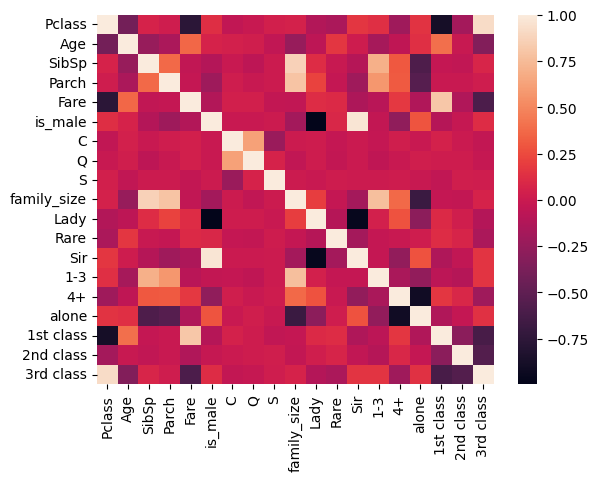

In [ ]:
df = pd.concat([train.drop('Survived', axis=1), test])
sns.heatmap(df.corr())

<ipython-input-155-aa4f4450a243>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

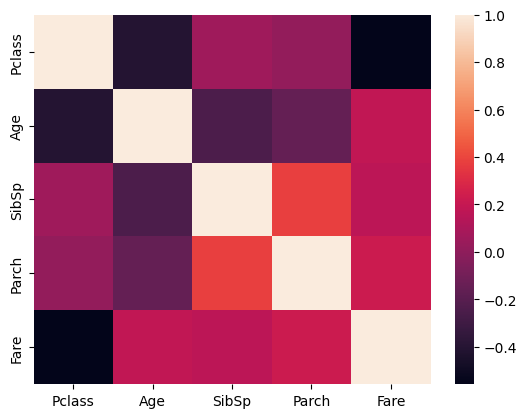

In [ ]:
sns.heatmap(df.corr())

In [ ]:
train['stat'] = train.Name.str.split(',').apply(lambda x:x[1].split('.')[0])
test['stat'] = test.Name.str.split(',').apply(lambda x:x[1].split('.')[0])

fullnames = ['Mister', 'Missis', 'Miss', 'Master', 'Don', 'Reverend', 'Doctor', 'Madame',
            'Miss', 'Major', 'Lady', 'Sir', 'Madmuaselle', 'Colonel', 'Captain',
            'Countess',  'Jonkheer']
dict_ = dict(zip(train.stat.unique(), fullnames))

train['stat'] = train.stat.replace(dict_)
test['stat'] = test.stat.replace(dict_)

df = pd.concat([train,test])

for i in df.loc[df.Age.isna()].stat.unique():
  id = df.loc[(df.stat==i)&(df.Age.isna())].index
  if i == 'Doctor':
    df.loc[id,'Age'] = df.loc[df.stat == i].Age.median()
  else:
    temp = df.loc[df.stat == i].Age
    if temp.isna().sum()!=temp.shape[0]:
      std = temp.std()
      mean = temp.mean()
    else:
      std = df.Age.std()
      mean = df.Age.mean()
    # id = df.loc[(df.stat==i)&(df.Age.isna())].index
    repl_arr = np.random.normal(mean,std,len(id))
    while (repl_arr<2).sum() != 0:
      repl_arr = np.random.normal(mean,std,len(id))
    # repl_arr = [k if k>1 else mean for k in repl_arr]
    df.loc[id, 'Age'] = repl_arr
df['Age'] = df.Age.round()

train['Age'] = df.Age.iloc[:train.shape[0]].astype(int)
test['Age'] = df.Age.iloc[train.shape[0]:].astype(int)

In [ ]:
df = pd.concat([train,test])

for i in df.Pclass:
  id = df.loc[(df.Pclass==i)&(df.Age.isna())].index
  temp = df.loc[df.Pclass == i].Age
  std = temp.std()
  mean = temp.mean()
  repl_arr = np.random.normal(mean,std,len(id))
  df.loc[id, 'Age'] = repl_arr
df['Age'] = df.Age.round()

train['Age'] = df.Age.iloc[:train.shape[0]].astype(int)
test['Age'] = df.Age.iloc[train.shape[0]:].astype(int)

In [ ]:
train_age = pd.concat([train['Age'], train_bu.Age, ], axis=1)
test_age = pd.concat([test['Age'], test_bu.Age], axis=1)

train_age.columns=['filled_train',  'wnan_train']#'Sex',
test_age.columns=['filled_test', 'wnan_test']

sex_col =  pd.concat([train.Sex, train.Sex, test.Sex, test.Sex]).reset_index(drop=True)
class_col = pd.concat([train.Pclass, train.Pclass, test.Pclass, test.Pclass]).reset_index(drop=True)


d1 = {'filled_train':'train',
         'filled_test':'test',
         'wnan_test':'test',
         'wnan_train':'train' }
d2 = {'filled_train':'filled',
         'filled_test':'filled',
         'wnan_test':'wnan',
         'wnan_train':'wnan'}
temp = pd.concat([train_age.melt(), test_age.melt()]).reset_index(drop=True)
temp = pd.concat([temp['value'],temp['variable'].replace(d1), temp['variable'].replace(d2), sex_col, class_col], axis=1)

temp.columns = ['age', 'subset', 'filled', 'sex', 'class']

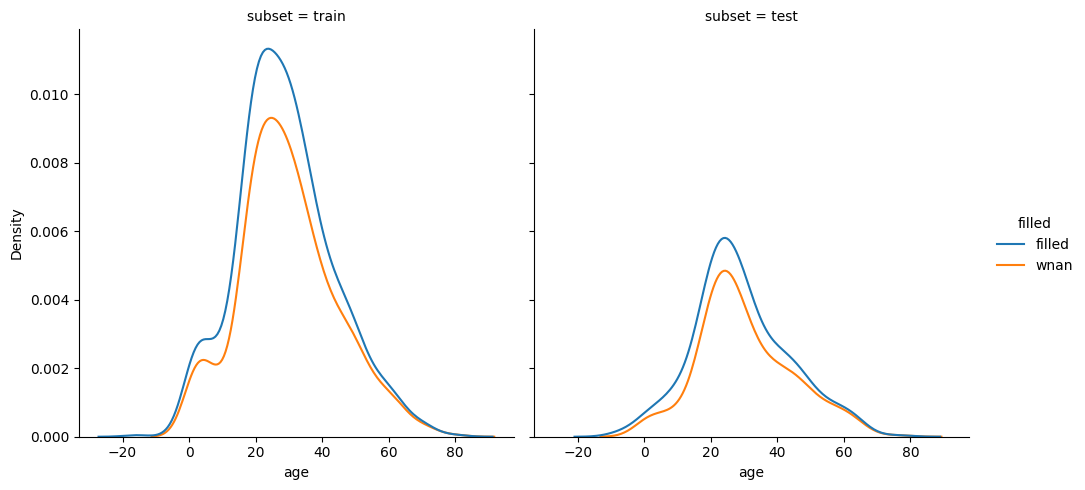

In [ ]:
sns.displot(data=temp, x='age', hue='filled', col='subset', kind='kde')

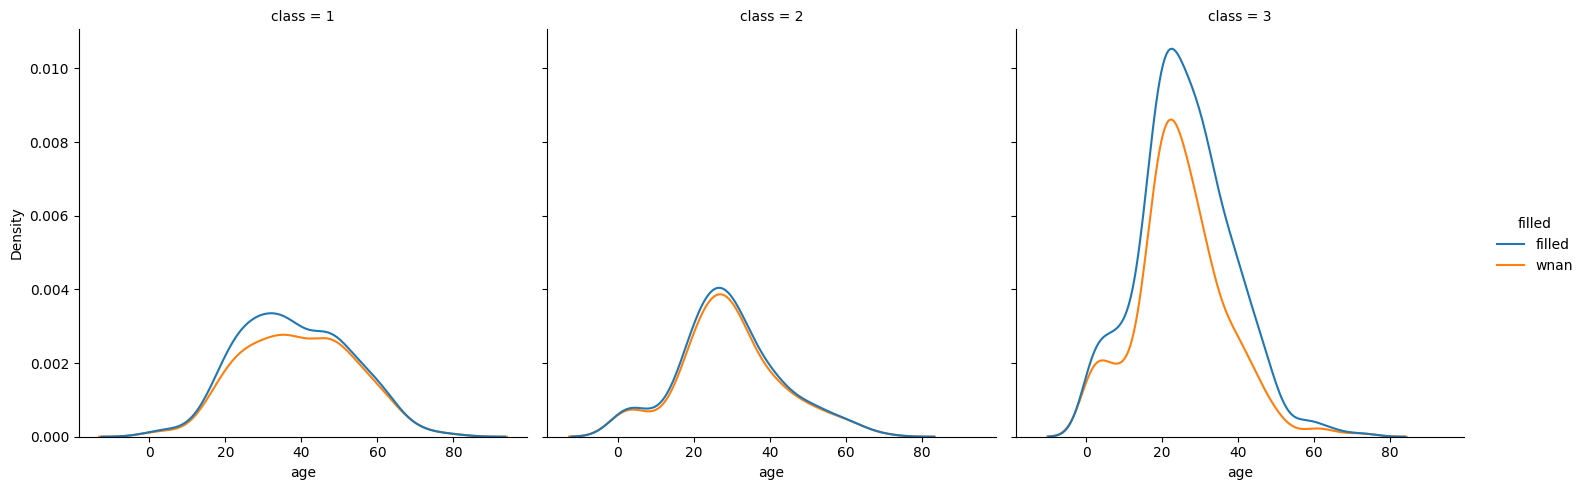

In [ ]:
a = sns.displot(data=temp, x='age', hue='filled', col='class', kind='kde')

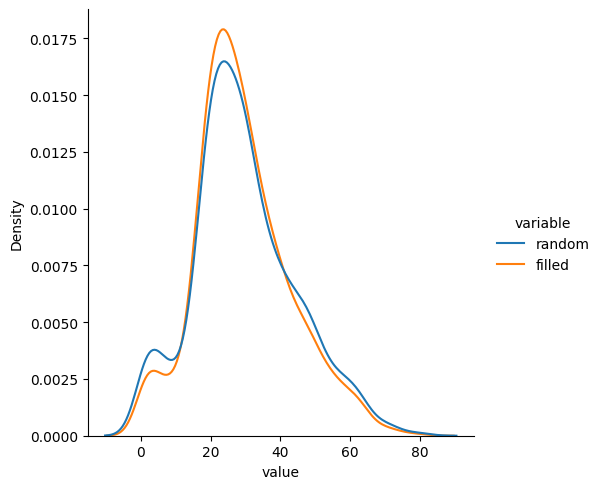

In [ ]:
t = temp.loc[temp.filled == 'wnan']
a1 =t.loc[t.age.isna()==False].age

t = temp.loc[temp.filled == 'filled'].age
a2 = pd.Series(np.random.choice(a1, t.shape[0]-a1.shape[0]))
a = pd.concat([a1, a2]).reset_index(drop=True)

temp2 = pd.concat([a, t.reset_index(drop=True)], axis=1 )
temp2.columns = ['random', 'filled']

sns.displot(data=temp2.melt(), x='value', hue='variable', kind='kde')

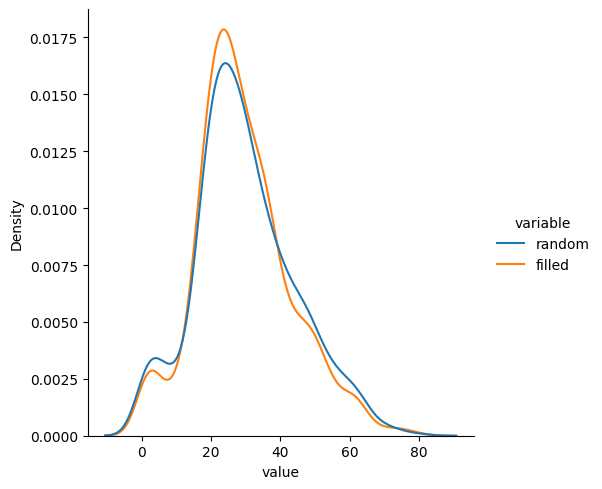

In [ ]:
t1 = pd.Series(np.random.choice(t, a1.shape))
a1.reset_index(drop=True, inplace=True)
temp2 = pd.concat([a1, t1], axis=1 )
temp2.columns = ['random', 'filled']

sns.displot(data=temp2.melt(), x='value', hue='variable', kind='kde')

In [ ]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
get_best_distribution(data.loc[~data.isna()])

p value for norm = 4.090734030520837e-06
p value for exponweib = 0.0010394734025497118
p value for weibull_max = 0.00036793342881385316
p value for weibull_min = 9.937416623563527e-06
p value for pareto = 1.749205034758647e-86
p value for genextreme = 0.0003678772194694297
Best fitting distribution: exponweib
Best p value: 0.0010394734025497118
Parameters for the best fit: (15.26537334292596, 2.860196772430548, -82.61306733997591, 74.93359349480347)


('exponweib',
 0.0010394734025497118,
 (15.26537334292596, 2.860196772430548, -82.61306733997591, 74.93359349480347))

##### fare

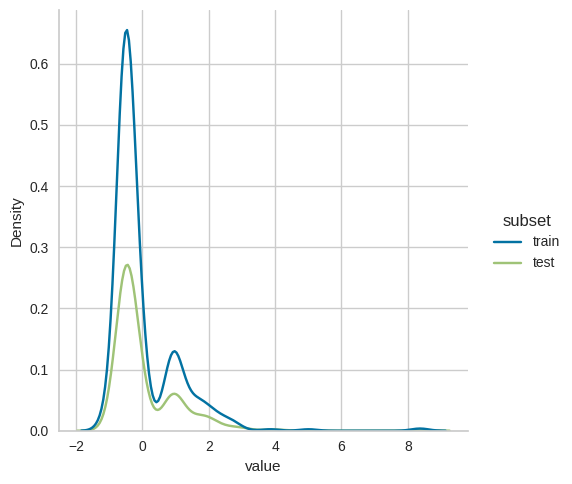

In [ ]:
a = pd.Series(['train' if i<test.shape[0] else 'test' for i in range(temp.shape[0])])
temp = pd.concat([pd.Series(np.random.choice(train.Fare, test.Fare.shape[0])), test.Fare])

temp = pd.concat([train.Fare, test.Fare]).reset_index(drop=True)
a = pd.Series(['train' if i<train.shape[0] else 'test' for i in range(temp.shape[0])])
temp = pd.concat([temp, a], axis=1)
temp.columns = ['value', 'subset']
sns.displot(data=temp, x='value', kind='kde', hue='subset', )

#### clustering vis

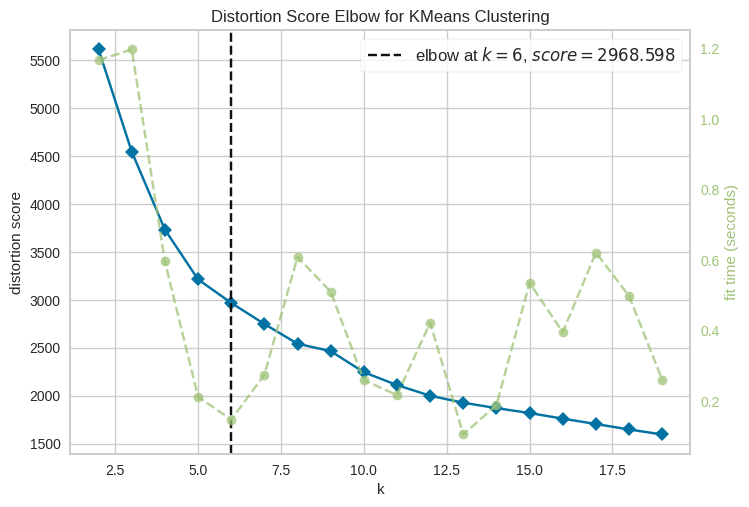

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

X = pd.concat([train.drop('Survived', axis=1),test])

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,20))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [ ]:
km = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)

X['cluster'] = km.fit_predict(X)
train['cluster'] = X['cluster'].iloc[:train.shape[0]]
test['cluster'] = X['cluster'].iloc[train.shape[0]:]

In [ ]:
import plotly.express as px

# X = pd.concat([train,test]).drop('Survived', axis=1)


pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color= X['cluster'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
import hdbscan
X = pd.concat([train,test]).drop(['Survived', 'cluster'], axis=1)
model = hdbscan.HDBSCAN()
clusters = model.fit_predict(X)
train['cluster'] = clusters[:train.shape[0]]
test['cluster'] = clusters[train.shape[0]:]

X = pd.concat([train,test]).drop('Survived', axis=1)


pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=X['cluster'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

#### train

In [ ]:
x_train = train.drop(['Survived'], axis=1)
y_train = train.Survived
test.drop('Survived', axis=1, inplace=True)


In [ ]:
model =  GradientBoostingClassifier()
model.fit(x_train, y_train)
y_preds = model.predict(test)


In [ ]:
subs['Survived'] = y_preds
subs['Survived'] = subs['Survived'].astype(int)
subs.to_csv(f'{base}sub_gb2.csv')

In [ ]:
from xgboost import XGBClassifier
model =  XGBClassifier()
model.fit(x_train, y_train)
y_preds = model.predict(test)

subs['Survived'] = y_preds
subs['Survived'] = subs['Survived'].astype(int)
subs.to_csv(f'{base}sub2.csv')

In [ ]:
# !pip install catboost
# from catboost import CatBoostClassifier
# model =  CatBoostClassifier()
# model.fit(x_train, y_train)
# # y_preds = model.predict(x_test)
# y_preds = model.predict(x_test)
# accuracy_score(y_test, y_preds)

# subs['Survived'] = y_preds
# subs['Survived'] = subs['Survived'].astype(int)
# subs.to_csv(f'{base}sub3.csv')

In [ ]:
y_preds = model.predict(x_test)
accuracy_score(y_test, y_preds)

0.820627802690583

### testing models

<Axes: >

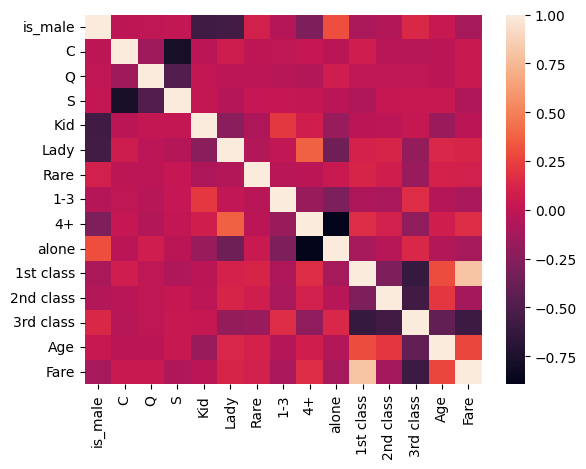

In [ ]:
sns.heatmap(train.drop(['Survived'], axis=1).corr())
# lst = ['is_male', 'Pclass']
# train.drop(lst,axis=1, inplace=True)
# test.drop(lst,axis=1, inplace=True)

In [ ]:
train.drop(['C', 'Lady', '4+', 'Survived'])
# train.columns

Index(['Survived', 'SibSp', 'Parch', 'C', 'Q', 'S', 'family_size', 'Lady',
       'Rare', 'Sir', '1-3', '4+', 'alone', '1st class', '2nd class',
       '3rd class', 'Age', 'Fare'],
      dtype='object')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train.drop('Survived', axis=1),train.Survived,
                                                    test_size=.25, random_state=42, shuffle=True, stratify=train.Survived)

# x_train, x_test, y_train, y_test = train_test_split(train.drop(['C', 'Lady', '4+', 'Survived'], axis=1),  train.Survived,
#                                                     test_size=.25, random_state=42, shuffle=True, stratify=train.Survived)
# features_importance = pd.DataFrame(x_train.columns)

In [ ]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(x_train, y_train)
y_preds = model_1.predict(x_test)
# result_list[0] = (f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.75
accuracy: 0.8117


In [ ]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(x_train, y_train)
y_preds = model_1.predict(x_test)
# result_list[0] = (f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.7442
accuracy: 0.8027


In [ ]:
model_2 = RandomForestClassifier()
model_2.fit(x_train, y_train)
y_preds = model_2.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.7394
accuracy: 0.8072


In [ ]:
model_2 = RandomForestClassifier(random_state=42)
model_2.fit(x_train, y_train)
y_preds = model_2.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.6795
accuracy: 0.7758


In [ ]:
model_3 = DecisionTreeClassifier()
model_3.fit(x_train, y_train)
y_preds = model_3.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.7458
accuracy: 0.7982


In [ ]:
model_3 = DecisionTreeClassifier(random_state=42)
model_3.fit(x_train, y_train)
y_preds = model_3.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.7232
accuracy: 0.7803


In [ ]:
model_4 = LinearSVC(max_iter=2000)
model_4.fit(x_train, y_train)
y_preds = model_4.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.76571
accuracy: 0.81614


In [ ]:
model_4 = LinearSVC(max_iter=2000, random_state=42)
model_4.fit(x_train, y_train)
y_preds = model_4.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')
# print(result_list[3])

f1: 0.77381
accuracy: 0.8296


In [ ]:
model_5 =  GradientBoostingClassifier(random_state=42)
model_5.fit(x_train, y_train)
y_preds = model_5.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.75294
accuracy: 0.81166


In [ ]:
model_6 =  AdaBoostClassifier(random_state=42)
model_6.fit(x_train, y_train)
y_preds = model_6.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.73743
accuracy: 0.78924


In [ ]:
model_7 = KNeighborsClassifier()
model_7.fit(x_train, y_train)
y_preds = model_7.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.679
accuracy: 0.7668


In [ ]:
from xgboost import XGBClassifier, XGBRFClassifier
model_8 = XGBClassifier(random_state=42)
model_8.fit(x_train, y_train)
y_preds = model_8.predict(x_test)
print(f'XGBC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

model_9 = XGBRFClassifier(random_state=42)
model_9.fit(x_train, y_train)
y_preds = model_9.predict(x_test)
print(f'XGBRFC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

XGBC /nf1: 0.75449
accuracy: 0.81614
XGBRFC /nf1: 0.725
accuracy: 0.80269


In [ ]:
from sklearn.linear_model import SGDClassifier
model_10 = SGDClassifier(random_state=42)
model_10.fit(x_train, y_train)
y_preds = model_10.predict(x_test)
print(f'SGDC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

SGDC /nf1: 0.74713
accuracy: 0.80269


In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
model_11 = PassiveAggressiveClassifier(random_state=42)
model_11.fit(x_train, y_train)
y_preds = model_11.predict(x_test)
print(f'SGDC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

SGDC /nf1: 0.71628
accuracy: 0.72646


In [ ]:
from sklearn.linear_model import RidgeClassifier
model_12 = RidgeClassifier(random_state=42)
model_12.fit(x_train, y_train)
y_preds = model_12.predict(x_test)
print(f'SGDC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

SGDC /nf1: 0.75862
accuracy: 0.81166


In [ ]:
from sklearn.neural_network import MLPClassifier
model_13 = MLPClassifier(random_state=42)
model_13.fit(x_train, y_train)
y_preds = model_13.predict(x_test)
print(f'SGDC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

SGDC /nf1: 0.70064
accuracy: 0.78924


In [ ]:
from sklearn.svm import NuSVC
model_14 = NuSVC(random_state=42, probability=True)
model_14.fit(x_train, y_train)
y_preds = model_14.predict(x_test)
print(f'SGDC /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

SGDC /nf1: 0.76471
accuracy: 0.82063


In [ ]:
from catboost import CatBoostClassifier
model_15 =  CatBoostClassifier(random_state=42, verbose=False)
model_15.fit(x_train, y_train)
y_preds = model_15.predict(x_test)
print(f'catboost /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.3 MB/s eta 0:00:00
catboost /nf1: 0.73418
accuracy: 0.81166


In [ ]:
from lightgbm import LGBMClassifier
model_16 = LGBMClassifier(num_leaves=25, verbose=-1, random_state=42)
model_16.fit(x_train, y_train)
y_preds = model_16.predict(x_test)
print(f'catboost /nf1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

catboost /nf1: 0.73054
accuracy: 0.79821


In [ ]:
ests = [('logreg' ,model_1), ('tree' ,model_3), ('linsvc' ,model_4), ('gbc' ,model_5), ('knn' ,model_7),
        ('rf' ,model_2), ('abc', model_6), ('XGBC', model_8), ('XGBRFC', model_9), ('SGDC', model_10), ('PAC', model_11),
         ('RC', model_12), ('MLPC', model_13), ('NuSVC',model_14), ('cbc', model_15), ('lightgbm',model_16)]
ensemble_1 = VotingClassifier(estimators=ests)#, voting='soft')
ensemble_1.fit(x_train, y_train)
y_preds = ensemble_1.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.77576
accuracy: 0.83408


In [ ]:
# ests = [('logreg' ,model_1), ('tree' ,model_3), ('linsvc' ,model_4), ('gbc' ,model_5), ('knn' ,model_7)]#, ('abc', model_6),('rf' ,model_2),]
ensemble_2 = StackingClassifier(estimators=ests)#, final_estimator=model_4)
ensemble_2.fit(x_train, y_train)
y_preds = ensemble_2.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.7619
accuracy: 0.82063


In [ ]:
from sklearn.naive_bayes import CategoricalNB
ensemble_3 = StackingClassifier(estimators=ests, final_estimator=model_1)
ensemble_3.fit(x_train, y_train)
y_preds = ensemble_3.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.76836
accuracy: 0.81614


In [ ]:
ests = [('logreg' ,model_1), ('tree' ,model_3), ('gbc' ,model_5), ('knn' ,model_7),
        ('rf' ,model_2), ('abc', model_6), ('XGBC', model_8), ('XGBRFC', model_9), ('MLPC', model_13), ('NuSVC',model_14),
         ('cbc', model_15), ('lightgbm',model_16)]
ensemble_4 = VotingClassifier(estimators=ests, voting='soft')
ensemble_4.fit(x_train, y_train)
y_preds = ensemble_4.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.76829
accuracy: 0.8296


In [ ]:
from sklearn.ensemble import BaggingClassifier
ensemble_5 = BaggingClassifier(estimator=model_2)
ensemble_5.fit(x_train, y_train)
y_preds = ensemble_5.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.74699
accuracy: 0.81166


In [ ]:
ensemble_5.fit(x_train, y_train)
y_preds = ensemble_5.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

f1: 0.74286
accuracy: 0.79821


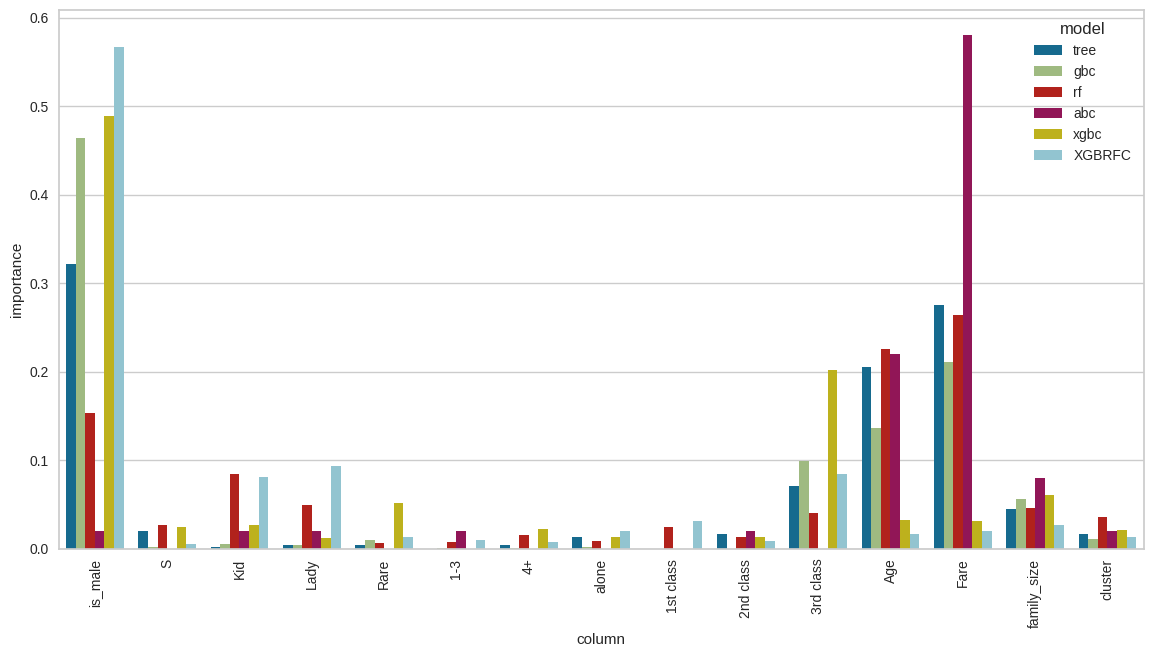

In [ ]:
# non_fe_list = []
# for i in ests:
#   try: i[1].feature_importances_,
#   except: ests.pop(i)

features_importance = pd.DataFrame(x_train.columns, columns=['models'])
coefs = pd.DataFrame(x_train.columns, columns=['models'])

ests_fe =[('tree' ,model_3), ('gbc' ,model_5), ('rf' ,model_2),
          ('abc', model_6), ('xgbc', model_8), ('XGBRFC',model_9 )]
ests_fe2 = [('logreg' ,model_1), ('linsvc' ,model_4),] #('sc', ensemble_2) ,('vc', ensemble_1), , ('knn' ,model_7)

for i in ests_fe:
  features_importance = pd.concat([features_importance, pd.Series(i[1].feature_importances_)], axis=1)
for i in ests_fe2:
  coefs = pd.concat([coefs, pd.Series(i[1].coef_.flatten())], axis=1)

features_importance.columns = ['models']+[i[0] for i in ests_fe]
features_importance.set_index('models', inplace=True)
coefs.columns = ['models']+[i[0] for i in ests_fe2]
coefs.set_index('models', inplace=True)

features_importance = pd.concat([features_importance.melt(),pd.Series(features_importance.index.to_list() * 6)], axis=1)
features_importance.columns = ['model', 'importance', 'column']

ax = plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
ax = sns.barplot(data = features_importance, hue='model', x='column', y='importance')

# ax = plt.figure(figsize=(14,7))


In [ ]:
coefs = pd.concat([coefs.melt(),pd.Series(coefs.index.to_list() * 2)], axis=1)

coefs.columns = ['model', 'coef', 'column']

<Axes: xlabel='column', ylabel='coef'>

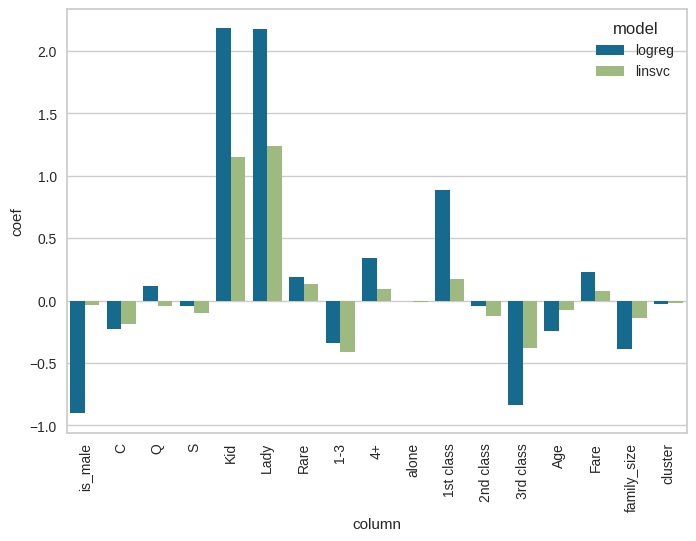

In [ ]:
# ax = plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
sns.barplot(data = coefs, hue='model', x='column', y='coef')

#### optimizers

In [ ]:
model_5 =  GradientBoostingClassifier(cv.best_params_)
model_5.fit(x_train, y_train)
y_preds = model_5.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),5)}\naccuracy: {round(accuracy_score(y_test,y_preds), 5)}')

TypeError: ignored

In [ ]:
gbc_params = {
    'loss': ['exponential', 'log_loss'],
    'learning_rate': [.07, .06, .05, .04, .03 ],
    'n_estimators': [i for i in range(83, 89, 2)],
    'criterion': ['friedman_mse', 'squared_error'],
    'tol': [1e-4, 9e-5, 2e-4]
}

cv = GridSearchCV(model_5, param_grid= gbc_params, scoring='accuracy')

cv.fit(x_train, y_train)
cv.best_score_

0.8278083267871171

In [ ]:
model_1 = LogisticRegression()
model_1.fit(x_train, y_train)
y_preds = model_1.predict(x_test)
# result_list[0] = (f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [1e-4, 5e-5, 1e-5, 1e-3, 5e-4],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],# ['liblinear', 'saga'],
    'max_iter':[100,  500, 1000, 1500, 2000]

}
model = LogisticRegression()
cv = GridSearchCV(model, param_grid= lr_params, scoring='accuracy')

cv.fit(train.drop(['Survived',], axis=1),  train.Survived)
cv.best_score_

In [ ]:
cv.best_params_

{'max_iter': 100, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}

In [ ]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [1e-4, 5e-5, 1e-5, 1e-3, 5e-4],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],# ['liblinear', 'saga'],
    'max_iter':[10, 15, 20, 25, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400]

}
model = LogisticRegression()
cv = HalvingGridSearchCV(model, param_grid= lr_params, scoring='accuracy', verbose=2)
cv.fit(train.drop(['Survived',], axis=1),  train.Survived)

In [ ]:
cv.best_score_

0.7984942886812045

In [ ]:
cv.best_params_

{'n_neighbors': 12, 'weights': 'uniform'}

In [ ]:
model_7 = KNeighborsClassifier(**cv.best_params_)
model_7.fit(x_train, y_train)
y_preds = model_7.predict(x_test)
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.7665
accuracy: 0.8251


In [ ]:
model_7 = KNeighborsClassifier()
params ={
    'n_neighbors': [i for i in range(5, 20)],
    'weights': ['uniform', 'distance']
}

cv = GridSearchCV(model_7, param_grid= params, scoring='accuracy')

cv.fit(x_train, y_train)
cv.best_score_

0.8143418247110313

In [ ]:
cv.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

#### roc auc

In [ ]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(x_train, y_train)
y_preds = model_1.predict(x_test)
# result_list[0] = (f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')
print(f'f1: {round(f1_score(y_test,y_preds),4)}\naccuracy: {round(accuracy_score(y_test,y_preds), 4)}')

f1: 0.7514
accuracy: 0.8072


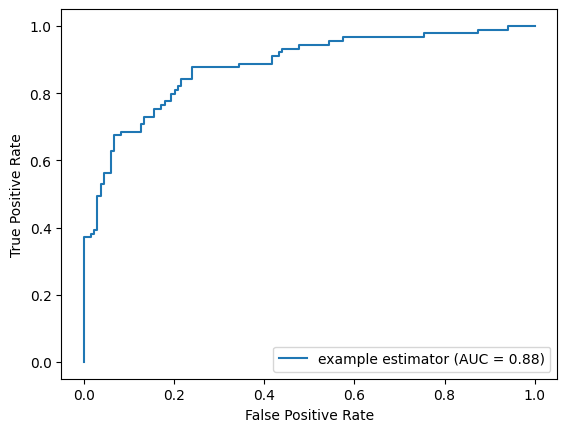

In [ ]:
from sklearn import metrics

y_score = model_1.predict_proba(x_test)

fpr, tpr, _ = metrics.roc_curve(y_test, y_score[:,1])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

plt.show()
